# 

In [2]:
import h5py
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler
import copy
import os.path

from torch.utils.data import Dataset, DataLoader
import argparse

import torch
import torch.utils.data
from torch import nn
from torch.cuda import amp
    
import torchsparse
from torchsparse import SparseTensor
from torchsparse import nn as spnn
from torchsparse.utils.collate import sparse_collate, sparse_collate_fn
from torchsparse.utils.quantize import sparse_quantize
from torch.cuda import amp
from typing import Any, Dict
from sklearn.metrics import confusion_matrix
import datetime

In [3]:
class CustomDataset(Dataset):
    def __init__(self, coords, feats, labels):
        coords = torch.tensor(coords, dtype=torch.int)
        feats = torch.tensor(feats, dtype=torch.float)
        labels = torch.tensor(labels, dtype=torch.long)
        self.coords = coords
        self.feats = feats
        self.labels = labels
        
    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        return self.coords[idx], self.feats[idx], self.labels[idx]

In [4]:
now = datetime.datetime.now()
datetime_str = now.strftime('%Y%m%d_%H%M%S')

ISOTOPE = "Mg22"
coords_train = np.load('../mg22simulated/' + ISOTOPE + "_coords_train.npy")
coords_val = np.load('../mg22simulated/' + ISOTOPE + "_coords_val.npy")
coords_test = np.load('../mg22simulated/' + ISOTOPE + "_coords_test.npy")
feats_train = np.load('../mg22simulated/' + ISOTOPE + "_feats_train.npy")
feats_val = np.load('../mg22simulated/' + ISOTOPE + "_feats_val.npy")
feats_test = np.load('../mg22simulated/' + ISOTOPE + "_feats_test.npy")
labels_train = np.load('../mg22simulated/' + ISOTOPE + "_labels_train.npy")
labels_val = np.load('../mg22simulated/' + ISOTOPE + "_labels_val.npy")
labels_test = np.load('../mg22simulated/' + ISOTOPE + "_labels_test.npy")

coords_train = coords_train[0:100]
feats_train = feats_train[0:100]
labels_train = labels_train[0:100]

coords_val = coords_val[0:50]
feats_val = feats_val[0:50]
labels_val = labels_val[0:50]

coords_test = coords_test[0:50]
feats_test = feats_test[0:50]
labels_test = labels_test[0:50]

In [5]:
# GPU Settings
device = 'cuda'
amp_enabled = True

model = nn.Sequential(
    spnn.Conv3d(4, 32, 3),
    spnn.BatchNorm(32),
    spnn.ReLU(True),
    spnn.Conv3d(32, 32, 3),
    spnn.BatchNorm(32),
    spnn.ReLU(True),
    spnn.Conv3d(32, 5, 1),
).to(device)

lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scaler = amp.GradScaler(enabled=amp_enabled)

In [6]:
num_epochs = 100
batch_size = 12

train_set = CustomDataset(coords_train, feats_train, labels_train)
train_loader = DataLoader(train_set, batch_size=batch_size)

val_set = CustomDataset(coords_val, feats_val, labels_val)
val_loader = DataLoader(val_set, batch_size=batch_size)

test_set = CustomDataset(coords_test, feats_test, labels_test)
test_loader = DataLoader(test_set, batch_size=batch_size)

train_steps = len(train_loader)
val_steps = len(val_loader)

test_len = len(test_loader.dataset) * 1476

In [7]:
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    
        model.train()
        running_loss = 0.0
        
        for batch_idx, (batch_coords, batch_feats, batch_labels) in enumerate(train_loader):
            
            tr_inputs_list = []
            tr_labels_list = []
        
            for i in range(len(batch_coords)):
                inputs_sparse = SparseTensor(coords=batch_coords[i], feats=batch_feats[i])
                labels_sparse = SparseTensor(coords=batch_coords[i], feats=batch_labels[i])
                tr_inputs_list.append(inputs_sparse)
                tr_labels_list.append(labels_sparse)
            
            tr_inputs = sparse_collate(tr_inputs_list).to(device=device)
            tr_labels = sparse_collate(tr_labels_list).to(device=device)
            
            with amp.autocast(enabled=amp_enabled):
                tr_outputs = model(tr_inputs)
                tr_labelsloss = tr_labels.feats.squeeze(-1)
                tr_loss = criterion(tr_outputs.feats, tr_labelsloss)
            
            running_loss += tr_loss.item()
            #print(f'[step {batch_idx + 1}] loss = {loss.item()}')
        
            optimizer.zero_grad()
            scaler.scale(tr_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        training_losses.append(running_loss / train_steps)
        print(f"[Epoch {epoch+1}] Running Loss: {running_loss / train_steps}")
    
        model.eval()
        torchsparse.backends.benchmark = True  # type: ignore
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_idx, (batch_coords, batch_feats, batch_labels) in enumerate(val_loader):
                
                v_inputs_list = []
                v_labels_list = []
            
                for i in range(len(batch_coords)):
                    inputs_sparse = SparseTensor(coords=batch_coords[i], feats=batch_feats[i])
                    labels_sparse = SparseTensor(coords=batch_coords[i], feats=batch_labels[i])
                    v_inputs_list.append(inputs_sparse)
                    v_labels_list.append(labels_sparse)
            
                v_inputs = sparse_collate(v_inputs_list).to(device=device)
                v_labels = sparse_collate(v_labels_list).to(device=device)
        
                n_correct = 0
                
                with amp.autocast(enabled=True):
                    v_outputs = model(v_inputs)
                    v_labelsloss = v_labels.feats.squeeze(-1)
                    v_loss = criterion(v_outputs.feats, v_labelsloss)
                
                val_loss += v_loss.item()
                
        validation_losses.append(val_loss / val_steps)
        print(f"[Epoch {epoch+1}] Validation Loss: {val_loss / val_steps}")

[Epoch 1] Running Loss: 1.6082791752285428
[Epoch 1] Validation Loss: 1.580078125
[Epoch 2] Running Loss: 1.495539665222168
[Epoch 2] Validation Loss: 1.5386258602142333
[Epoch 3] Running Loss: 1.449671361181471
[Epoch 3] Validation Loss: 1.5554349422454834
[Epoch 4] Running Loss: 1.412604186269972
[Epoch 4] Validation Loss: 1.5119821310043335
[Epoch 5] Running Loss: 1.3538760211732652
[Epoch 5] Validation Loss: 1.4119521379470825
[Epoch 6] Running Loss: 1.305249359872606
[Epoch 6] Validation Loss: 1.2961532592773437
[Epoch 7] Running Loss: 1.2558684216605291
[Epoch 7] Validation Loss: 1.1666517019271851
[Epoch 8] Running Loss: 1.1931024657355414
[Epoch 8] Validation Loss: 1.0692976236343383
[Epoch 9] Running Loss: 1.141782071855333
[Epoch 9] Validation Loss: 1.0095831871032714
[Epoch 10] Running Loss: 1.090013451046414
[Epoch 10] Validation Loss: 0.9870911717414856
[Epoch 11] Running Loss: 1.0368653668297663
[Epoch 11] Validation Loss: 0.939389967918396
[Epoch 12] Running Loss: 0.9840

In [13]:
MODEL_PATH = '../models/'
LOSS_PATH = '../loss_data/'

filename = f"epochs{num_epochs}_lr{lr}_{datetime_str}.pth"
torch.save(model.state_dict(), MODEL_PATH + filename)

tr_filename = f"trainloss_{datetime_str}.npy"
v_filename = f"valloss_{datetime_str}.npy"
np.save(LOSS_PATH + tr_filename, training_losses)
np.save(LOSS_PATH + v_filename, validation_losses)

print('Finished Training')

Finished Training


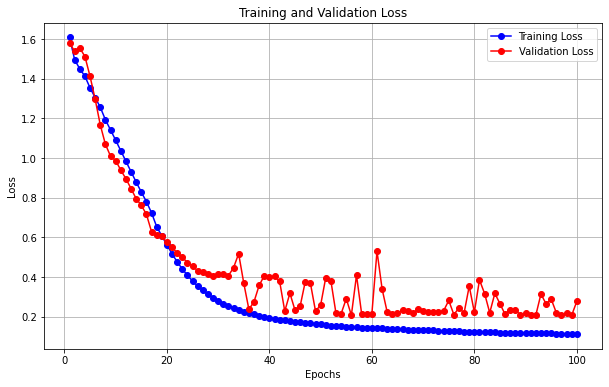

In [11]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, '-o', label='Training Loss', color='blue')
plt.plot(epochs, validation_losses, '-o', label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
coords_test = coords_test[0:50]
feats_test = feats_test[0:50]
labels_test = labels_test[0:50]

model.eval()

torchsparse.backends.benchmark = True  # type: ignore

with torch.no_grad():
    
    all_preds = []
    all_labels = []
    all_preds = np.array(all_preds)
    
    
    for batch_idx, (batch_coords, batch_feats, batch_labels) in enumerate(test_loader):
        inputs_list = []
        labels_list = []
    
        for i in range(len(batch_coords)):
            inputs_sparse = SparseTensor(coords=batch_coords[i], feats=batch_feats[i])
            labels_sparse = SparseTensor(coords=batch_coords[i], feats=batch_labels[i])
            inputs_list.append(inputs_sparse)
            labels_list.append(labels_sparse)
    
        inputs = sparse_collate(inputs_list).to(device=device)
        labels = sparse_collate(labels_list).to(device=device)

        n_correct = 0
        
        with amp.autocast(enabled=True):
            outputs = model(inputs)
            
            
            labelsloss = labels.feats.squeeze(-1)
            loss = criterion(outputs.feats, labelsloss)
            _, predicted = torch.max(outputs.feats, 1)

            all_preds = np.concatenate((all_preds, predicted.cpu().numpy()))
            n_correct += (predicted == labelsloss).sum().item()

    
    
    cm = confusion_matrix(labels_test.reshape(-1), all_preds)
    
    acc = 100.0 * n_correct / (test_len)
    print(f'Accuracy of the model: {acc:.3g} %')


Accuracy of the model: 3.64 %


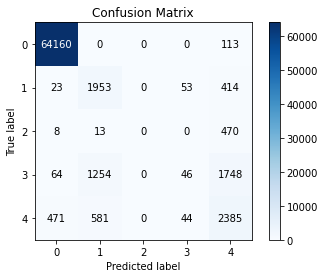

In [9]:
# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(cm.shape[0])  # Assuming all classes are present in your matrix
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add the values in the cells of the confusion matrix to the plot
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j],
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()